In [49]:
# CELL A — Load & Clean Silver Demand Data (World Silver Survey 2003–2024)
# This cell:
# 1) Loads the Excel file directly from GitHub
# 2) Normalizes/cleans column names
# 3) Recomputes industrial/jewelry/investment percentages
# 4) Performs basic validation + sanity checks

import pandas as pd
import numpy as np
import re
from pathlib import Path

# --- 1. Load file ---
# Loading from GitHub repository to ensure reproducibility.
excel_url = "https://raw.githubusercontent.com/rkramsharvesh/silver-gold-analysis/main/silver_demand_composition.xlsx"
df = pd.read_excel(excel_url)

# --- 2. Normalize column names (handle NBSP, whitespace, lowercasing) ---
def clean_col(c):
    if not isinstance(c, str):
        return c
    c2 = c.replace('\xa0', ' ')          # handle NBSP
    c2 = re.sub(r'\s+', ' ', c2).strip() # collapse spaces
    c2 = c2.replace(" ", "_").lower()    # snake-case
    return c2

df.columns = [clean_col(c) for c in df.columns]

print("Cleaned columns:\n", df.columns.tolist(), "\n")

# --- 3. Recompute derived pct columns ---
df['industrial_pct_calc'] = (df['industrial_moz'] / df['total_demand_moz']) * 100
df['jewelry_pct_calc']    = (df['jewelry_moz']    / df['total_demand_moz']) * 100
df['investment_pct_calc'] = (
    (df['coin_bar_moz'] + df['silverware_moz']) / df['total_demand_moz']
) * 100

# --- 4. Compare provided vs calculated (if provided columns exist) ---
for col in ['industrial_pct', 'jewelry_pct', 'investment_pct']:
    if col in df.columns:
        diff = df[col] - df[col + "_calc"]
        print(f"{col}: mean diff={diff.mean():.8f}, max abs diff={diff.abs().max():.8f}")
    else:
        print(f"{col} not found in sheet.")

# --- 5. Basic data checks ---
print("\nMissing values per column:\n", df.isna().sum())
print("\nYear range:", df['year'].min(), "to", df['year'].max())

# --- 6. Save cleaned version for downstream use ---
df.to_csv("silver_demand_cleaned.csv", index=False)
print("\nSaved cleaned file as silver_demand_cleaned.csv")

# Display preview
df.head()

Cleaned columns:
 ['year', 'mine_production', 'recycling', 'total_supply', 'industrial_moz', 'of_which_photovoltaic', 'jewelry_moz', 'coin_bar_moz', 'silverware_moz', 'total_demand_moz', 'price_per_oz', 'industrial_pct', 'jewelry_pct', 'investment_pct'] 

industrial_pct: mean diff=0.00000000, max abs diff=0.00000000
jewelry_pct: mean diff=0.00000000, max abs diff=0.00000000
investment_pct: mean diff=0.00000000, max abs diff=0.00000000

Missing values per column:
 year                     0
mine_production          0
recycling                0
total_supply             0
industrial_moz           0
of_which_photovoltaic    0
jewelry_moz              0
coin_bar_moz             0
silverware_moz           0
total_demand_moz         0
price_per_oz             0
industrial_pct           0
jewelry_pct              0
investment_pct           0
industrial_pct_calc      0
jewelry_pct_calc         0
investment_pct_calc      0
dtype: int64

Year range: 2003 to 2024

Saved cleaned file as silver_dema

,year,mine_production,recycling,total_supply,industrial_moz,of_which_photovoltaic,jewelry_moz,coin_bar_moz,silverware_moz,total_demand_moz,price_per_oz,industrial_pct,jewelry_pct,investment_pct,industrial_pct_calc,jewelry_pct_calc,investment_pct_calc
0,2003,597.2,196.0,889.8,561.3,2.5,186.8,35.7,85.1,889.8,4.87,63.081591,20.993482,13.576085,63.081591,20.993482,13.576085
1,2004,613.6,198.7,874.1,608.9,3.0,187.1,53.0,68.1,917.1,6.65,66.394068,20.401265,13.204667,66.394068,20.401265,13.204667
2,2005,639.9,203.4,955.1,639.1,7.3,187.6,51.6,68.3,946.5,7.31,67.522451,19.820391,12.667723,67.522451,19.820391,12.667723
3,2006,643.3,207.1,917.2,646.7,8.9,175.2,48.7,62.1,932.8,11.55,69.328902,18.782161,11.878216,69.328902,18.782161,11.878216
4,2007,667.7,203.7,889.8,646.0,12.5,182.3,61.6,60.2,950.2,13.38,67.985687,19.185435,12.818354,67.985687,19.185435,12.818354


### Action Required: Upload Data Files

To proceed with the notebook, please upload the following files to your Colab environment:

1.  **`silver_demand_composition.xlsx`**
2.  **`market_monthly_series.csv`**

YouYou can do this by clicking the 'Files' icon on the left sidebar (folder icon), then clicking the 'Upload to session storage' icon (file with an arrow pointing up), and selecting the files from your local machine. Once uploaded, please re-run the code cells above that failed (CELL A and the cell for `market_monthly_series.csv`).

In [50]:
# Parse noisy market CSV (row-headers like 'Ticker','Date') into clean monthly DataFrame
# Loading from GitHub repository to ensure reproducibility.
csv_url = "https://raw.githubusercontent.com/rkramsharvesh/silver-gold-analysis/main/market_monthly_series.csv"
raw = pd.read_csv(csv_url, header=None, dtype=str)

# extract possible column names (row0) and tickers (row1)
col_names = raw.iloc[0, 1:].astype(str).str.strip().tolist()
tickers   = raw.iloc[1, 1:].astype(str).str.strip().tolist()

# find first row that looks like a date
start_row = next((i for i, v in enumerate(raw[0].astype(str)) if v[:4].isdigit()), 3)

data_part = raw.iloc[start_row:, 1:].reset_index(drop=True)
dates = raw.iloc[start_row:, 0].reset_index(drop=True)

data_numeric = data_part.apply(pd.to_numeric, errors='coerce')

# choose column headers
if all(name == '' for name in col_names):
    cols = tickers if any(tickers) else [f"col_{i}" for i in range(data_numeric.shape[1])]
else:
    cols = col_names
if len(cols) != data_numeric.shape[1]:
    cols = tickers if len(tickers) == data_numeric.shape[1] else [f"col_{i}" for i in range(data_numeric.shape[1])]

data_numeric.columns = cols

# parse dates and set index
dt_index = pd.to_datetime(dates, errors='coerce', infer_datetime_format=True)
if dt_index.isna().any():
    dt_index = pd.to_datetime(dates, errors='coerce')
if dt_index.isna().any():
    raise ValueError("Date parsing failed. Paste sample date strings if you need help.")

data_numeric.index = dt_index
data_numeric.index.name = "date"
data_numeric = data_numeric.dropna(how='all').sort_index()

# save outputs
data_numeric.to_csv("market_monthly_series_parsed.csv")
market_annual = data_numeric.resample("ME").mean()
market_annual.index = market_annual.index.year
market_annual.index.name = "year"
market_annual.to_csv("market_annual_series_parsed.csv")

print("Parsed columns:", list(data_numeric.columns))
print("Date range:", data_numeric.index.min(), "to", data_numeric.index.max())

Parsed columns: ['silver_fut', 'silver_etf', 'gold_fut', 'gold_etf', 'vix', 'dxy', 'tenyr']
Date range: 2003-01-31 00:00:00 to 2024-12-31 00:00:00


/tmp/ipython-input-3687081035.py:29: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt_index = pd.to_datetime(dates, errors='coerce', infer_datetime_format=True)


In [51]:
# Create annual market series and align with demand
mkt = pd.read_csv("market_monthly_series_parsed.csv", index_col=0, parse_dates=True)
market_annual = mkt.resample("Y").mean()
market_annual.index = market_annual.index.year
market_annual.index.name = "year"
market_annual.to_csv("market_annual_series.csv")

demand = pd.read_csv("silver_demand_cleaned.csv").set_index("year")
aligned = demand.join(market_annual, how="left")
aligned.to_csv("aligned_annual_demand_market.csv")

print("Aligned columns:", aligned.columns.tolist())
print("Aligned years:", aligned.index.min(), "to", aligned.index.max())

Aligned columns: ['mine_production', 'recycling', 'total_supply', 'industrial_moz', 'of_which_photovoltaic', 'jewelry_moz', 'coin_bar_moz', 'silverware_moz', 'total_demand_moz', 'price_per_oz', 'industrial_pct', 'jewelry_pct', 'investment_pct', 'industrial_pct_calc', 'jewelry_pct_calc', 'investment_pct_calc', 'silver_fut', 'silver_etf', 'gold_fut', 'gold_etf', 'vix', 'dxy', 'tenyr']
Aligned years: 2003 to 2024


/tmp/ipython-input-202568641.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  market_annual = mkt.resample("Y").mean()


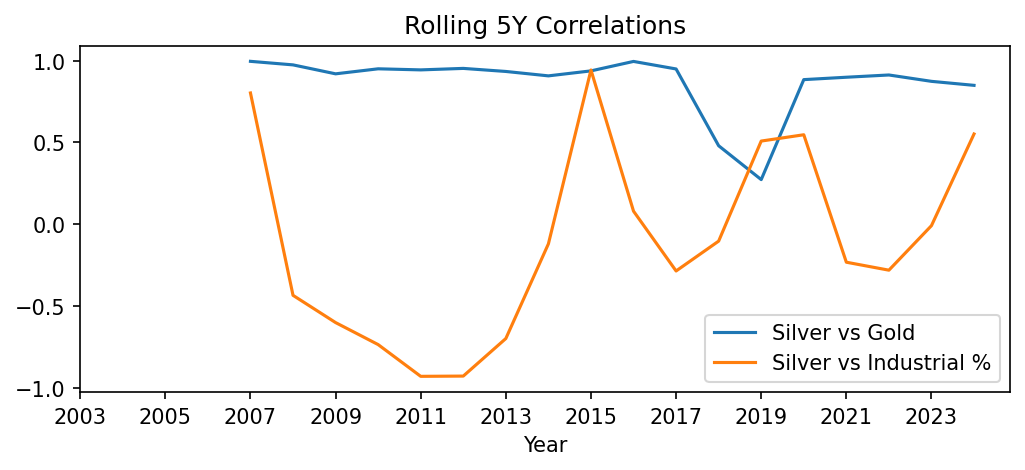

In [52]:
# Rolling 5-year correlations
aligned['silver_price'] = aligned['silver_fut']
aligned['gold_price']   = aligned['gold_fut']

roll_corr_gold = aligned['silver_price'].rolling(5).corr(aligned['gold_price'])
roll_corr_ind  = aligned['silver_price'].rolling(5).corr(aligned['industrial_pct_calc'])

ax = roll_corr_gold.plot(figsize=(8,3), grid=True, label="Silver vs Gold")
roll_corr_ind.plot(ax=ax, label="Silver vs Industrial %")

ax.set_title("Rolling 5Y Correlations")
ax.set_xlabel("Year")

years = aligned.index.to_list()
ax.set_xticks(years[::2])
ax.set_xticklabels(years[::2])

ax.legend()

In [53]:
# Unit-root tests (ADF + KPSS) for core annual series; results saved to CSV
from statsmodels.tsa.stattools import adfuller, kpss
series_list = ['silver_price','gold_price','total_demand_moz','industrial_moz','price_per_oz']
results = []

for s in series_list:
    y = aligned[s].dropna()
    if y.empty:
        print(f"{s}: no data")
        continue
    adf_p = adfuller(y, autolag='AIC')[1]
    kpss_p = kpss(y, regression='c', nlags='auto')[1]
    results.append({'series': s, 'n_obs': len(y), 'adf_p': adf_p, 'kpss_p': kpss_p})

res_df = pd.DataFrame(results).set_index('series')
res_df.to_csv("unit_root_results.csv")
print(res_df.to_string())

                  n_obs     adf_p    kpss_p
series                                     
silver_price         22  0.001072  0.096245
gold_price           22  0.965098  0.012563
total_demand_moz     22  0.117162  0.016669
industrial_moz       22  0.000099  0.100000
price_per_oz         22  0.000000  0.091546


/tmp/ipython-input-3809190287.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(y, regression='c', nlags='auto')[1]


In [54]:
# Johansen on I(1) variables (auto-detect)
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

ur = pd.read_csv("unit_root_results.csv", index_col=0)
i1_vars = ur[ur['adf_p'] > 0.05].index.tolist()
print("I(1) candidates (ADF p>0.05):", i1_vars)

if len(i1_vars) < 2:
    print("Fewer than 2 I(1) series — skipping Johansen.")
else:
    y = aligned[i1_vars].dropna()
    # choose k_ar_diff=1 as baseline; tune if residuals suggest more lags
    j = coint_johansen(y, det_order=0, k_ar_diff=1)
    import numpy as np
    trace_stats = j.lr1
    crit_vals = j.cvt  # columns: 90,95,99
    out = pd.DataFrame({
        'trace_stat': trace_stats,
        'c90': crit_vals[:,0],
        'c95': crit_vals[:,1],
        'c99': crit_vals[:,2]
    }, index=[f"r<= {i}" for i in range(len(trace_stats))])
    out.to_csv("johansen_results.csv")
    print(out.to_string())

I(1) candidates (ADF p>0.05): ['gold_price', 'total_demand_moz']
       trace_stat      c90      c95      c99
r<= 0   14.755004  13.4294  15.4943  19.9349
r<= 1    0.007926   2.7055   3.8415   6.6349


In [55]:
# Toda-Yamamoto with constrained lag search (stable for small samples)
from statsmodels.tsa.api import VAR
df = aligned[['silver_price','gold_price','industrial_moz']].dropna()

sel = VAR(df).select_order(2)      # restrict to max 2 lags
lag = sel.selected_orders.get('aic', 1)
if lag > 2:
    lag = 2
lag_aug = lag + 1

model = VAR(df).fit(lag_aug)

res_gold = model.test_causality('silver_price', ['gold_price'], kind='wald')
res_ind  = model.test_causality('silver_price', ['industrial_moz'], kind='wald')

print("Lag used:", lag, " | Augmented:", lag_aug)
print("Gold → Silver p:", res_gold.pvalue)
print("Ind → Silver p:",  res_ind.pvalue)

Lag used: 2  | Augmented: 3
Gold → Silver p: 0.19132905852851387
Ind → Silver p: 0.084519167729616


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [56]:
# Bai–Perron style break detection (ruptures)
import ruptures as rpt
y = aligned['silver_price'].dropna().values
algo = rpt.Binseg(model="l2").fit(y)
bkpts = algo.predict(n_bkps=3)
print("Breakpoints:", bkpts)
years = aligned.index.tolist(); print([years[i-1] for i in bkpts])

Breakpoints: [5, 10, 20, 22]
[2007, 2012, 2022, 2024]


In [57]:
# MIDAS regression: monthly silver returns ~ monthly gold returns + annual industrial_moz (MIDAS lag)
import numpy as np
import pandas as pd
import statsmodels.api as sm

# prepare monthly silver & gold returns
m = pd.read_csv("market_monthly_series_parsed.csv", index_col=0, parse_dates=True)
m = m[['silver_fut','gold_fut']].dropna()

m['silver_ret'] = np.log(m['silver_fut']).diff()
m['gold_ret']   = np.log(m['gold_fut']).diff()

# prepare annual industrial data
d = aligned['industrial_moz'].dropna()

# create monthly industrial series using MIDAS weights
def beta_weights(k, a, b):
    x = np.arange(1, k+1)
    w = (x**(a-1)) * ((k-x+1)**(b-1))
    return w / w.sum()

k = 12  # 1-year annual data expanded to 12 monthly values
a0, b0 = 1.5, 1.5

w = beta_weights(k, a0, b0)

# expand industrial_moz into monthly MIDAS regressor
ind_midas = m.index.to_series().apply(lambda dt: d.get(dt.year, np.nan))
ind_midas = ind_midas.rolling(window=k, min_periods=k).apply(lambda x: np.sum(w * x[::-1]), raw=True)

# assemble regression dataset
df = pd.DataFrame({
    'silver_ret': m['silver_ret'],
    'gold_ret':   m['gold_ret'],
    'ind_midas':  ind_midas
}).dropna()

# OLS MIDAS regression
X = sm.add_constant(df[['gold_ret','ind_midas']])
model = sm.OLS(df['silver_ret'], X).fit()

print(model.summary())
model.params.to_csv("midas_params.csv")

                            OLS Regression Results                            
Dep. Variable:             silver_ret   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     183.5
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           9.20e-50
Time:                        23:44:59   Log-Likelihood:                 361.20
No. Observations:                 253   AIC:                            -716.4
Df Residuals:                     250   BIC:                            -705.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.029      0.092      0.9

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

aligned_path = Path("aligned_annual_demand_market.csv")
monthly_path = Path("market_monthly_series_parsed.csv")

# load data
aligned = pd.read_csv(aligned_path, index_col=0)
mkt_monthly = pd.read_csv(monthly_path, index_col=0, parse_dates=True)

# configure plotting
plt.rcParams.update({'figure.dpi':150, 'savefig.dpi':150})
out_dir = Path(".")


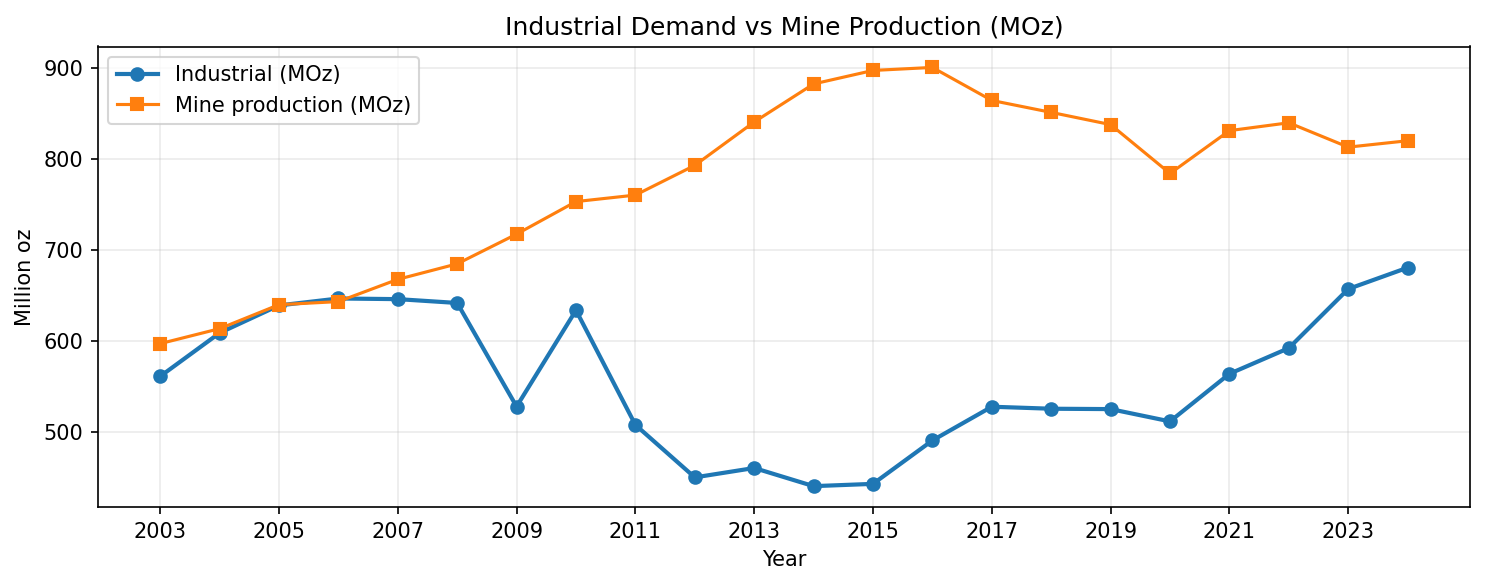

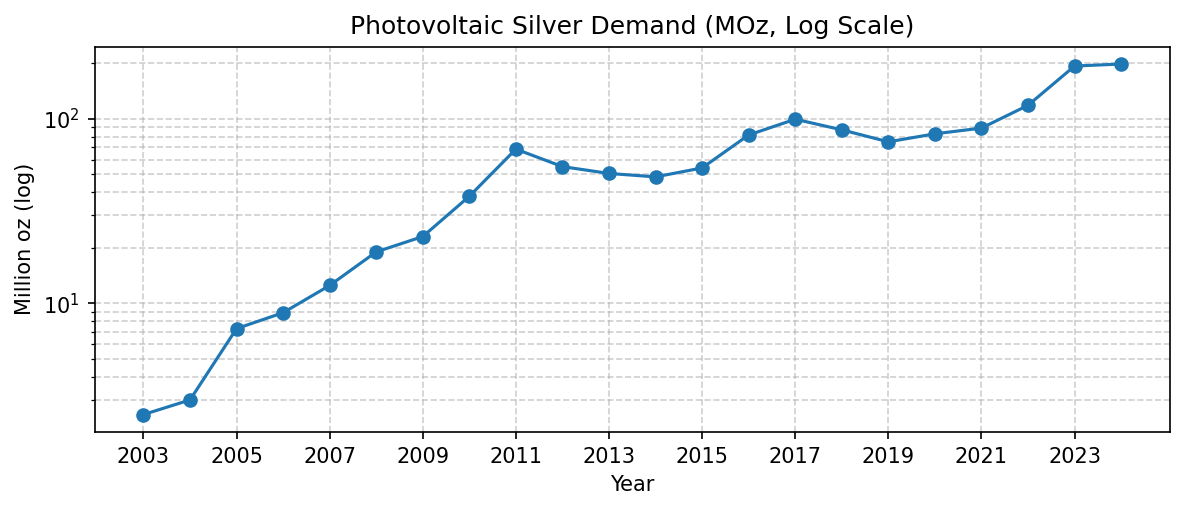

In [59]:
years = aligned.index.astype(int)

# Industrial demand vs mine production (compare absolute levels)
plt.figure(figsize=(10,4))
plt.plot(years, aligned['industrial_moz'], marker='o', label='Industrial (MOz)', linewidth=2)
plt.plot(years, aligned['mine_production'], marker='s', label='Mine production (MOz)', linewidth=1.5)
plt.title("Industrial Demand vs Mine Production (MOz)")
plt.xlabel("Year"); plt.ylabel("Million oz")
plt.xticks(years[::2]); plt.grid(alpha=0.25); plt.legend()
plt.tight_layout(); plt.savefig(out_dir/"fig_industrial_vs_mine.png"); plt.show()

plt.figure(figsize=(8,3.5))
plt.plot(years, aligned['of_which_photovoltaic'], marker='o')
plt.yscale('log')
plt.title("Photovoltaic Silver Demand (MOz, Log Scale)")
plt.xlabel("Year"); plt.ylabel("Million oz (log)")
plt.xticks(years[::2]); plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout(); plt.savefig(out_dir/"fig_pv_demand_log.png")
plt.show()

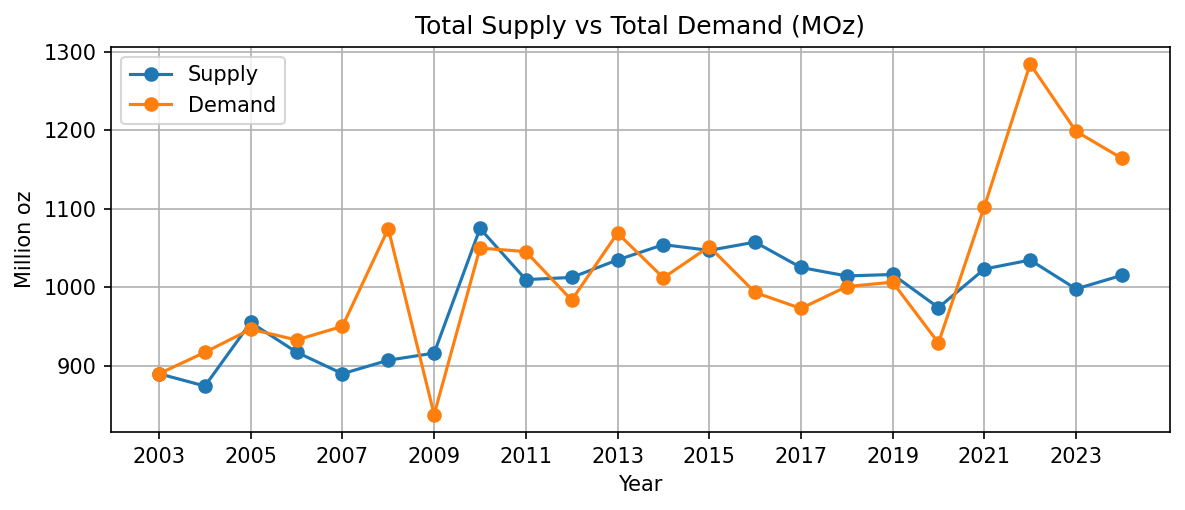

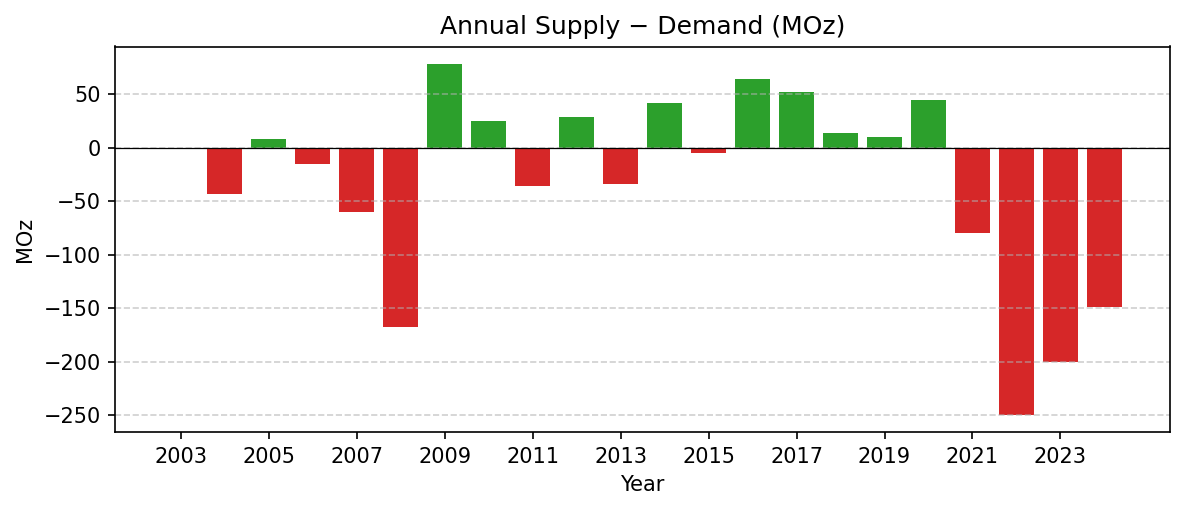

In [60]:
plt.figure(figsize=(8,3.5))
plt.plot(years, aligned['total_supply'], marker='o', label='Supply')
plt.plot(years, aligned['total_demand_moz'], marker='o', label='Demand')
plt.title("Total Supply vs Total Demand (MOz)")
plt.xlabel("Year"); plt.ylabel("Million oz")
plt.xticks(years[::2]); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(out_dir/"fig_supply_vs_demand.png")
plt.show()

balance = aligned['total_supply'] - aligned['total_demand_moz']
plt.figure(figsize=(8,3.5))
colors = ['tab:red' if v < 0 else 'tab:green' for v in balance]
plt.bar(years, balance, color=colors)
plt.axhline(0, color='k', linewidth=0.6)
plt.title("Annual Supply − Demand (MOz)")
plt.xlabel("Year"); plt.ylabel("MOz")
plt.xticks(years[::2]); plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(); plt.savefig(out_dir/"fig_supply_balance.png")
plt.show()


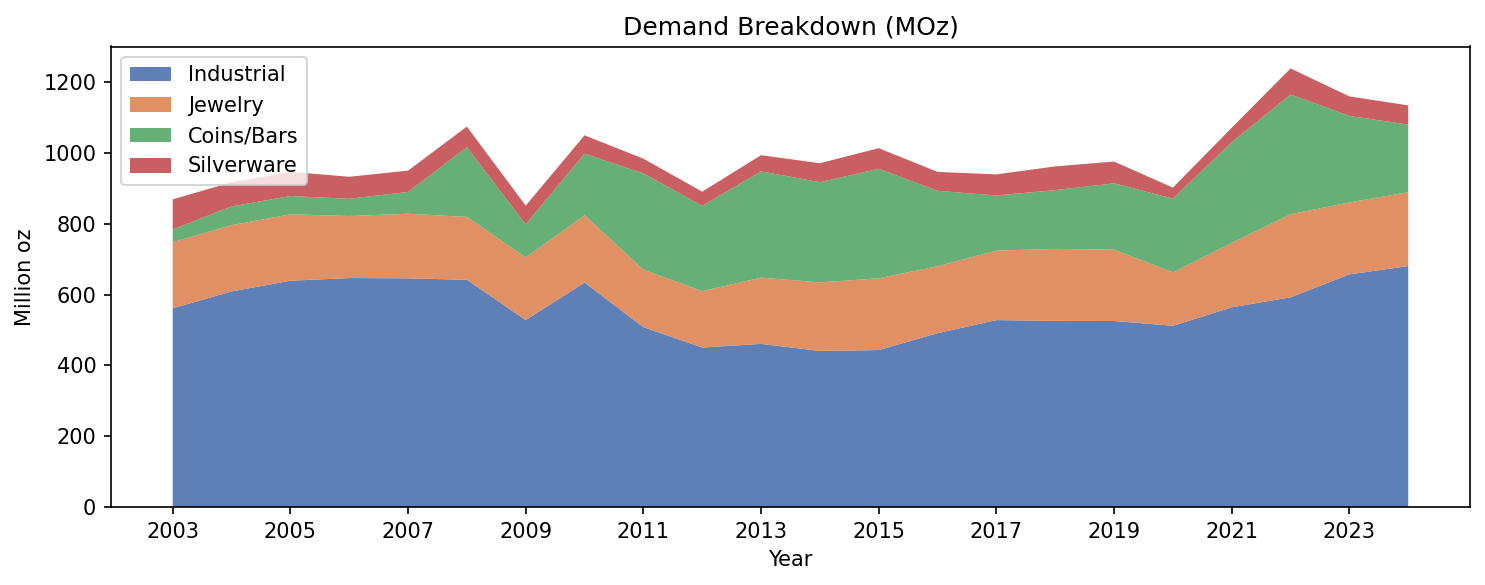

In [61]:
years = aligned.index.astype(int)

colors = [
    "#4C72B0",  # steel blue (Industrial)
    "#DD8452",  # warm orange (Jewelry)
    "#55A868",  # desaturated green (Coins/Bars)
    "#C44E52"   # muted red (Silverware)
]

plt.figure(figsize=(10,4))
plt.stackplot(
    years,
    aligned['industrial_moz'].fillna(0),
    aligned['jewelry_moz'].fillna(0),
    aligned['coin_bar_moz'].fillna(0),
    aligned['silverware_moz'].fillna(0),
    labels=['Industrial','Jewelry','Coins/Bars','Silverware'],
    colors=colors,
    alpha=0.9
)
plt.title("Demand Breakdown (MOz)")
plt.xlabel("Year")
plt.ylabel("Million oz")
plt.xticks(years[::2])
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(out_dir/"fig_demand_breakdown_better.png")
plt.show()

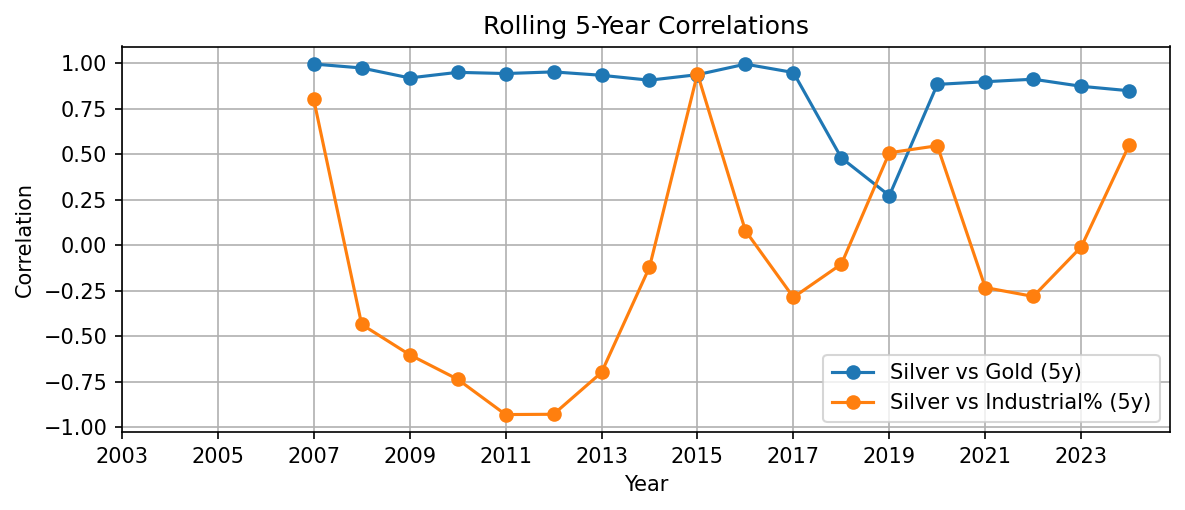

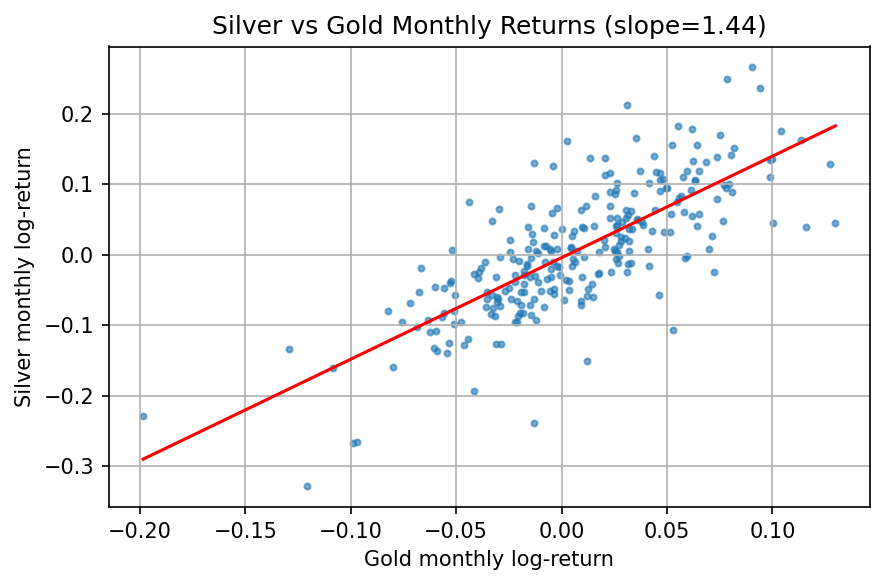

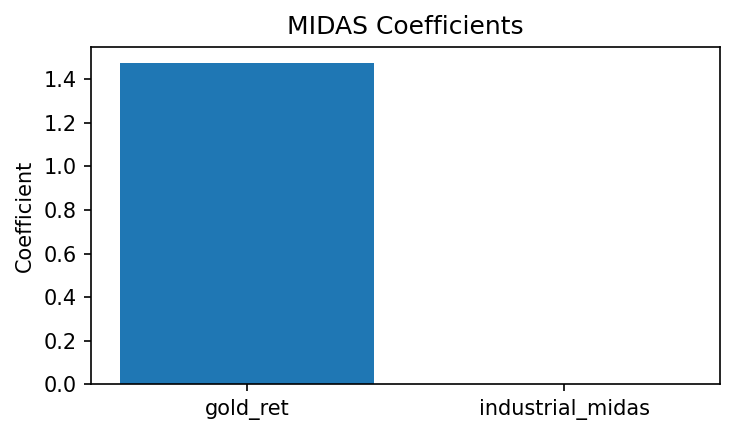

In [62]:
roll5 = aligned['silver_fut'].rolling(5).corr(aligned['gold_fut'])
roll5_ind = aligned['silver_fut'].rolling(5).corr(aligned['industrial_pct_calc'])

plt.figure(figsize=(8,3.5))
plt.plot(years, roll5, marker='o', label='Silver vs Gold (5y)')
plt.plot(years, roll5_ind, marker='o', label='Silver vs Industrial% (5y)')
plt.title("Rolling 5-Year Correlations")
plt.xlabel("Year"); plt.ylabel("Correlation")
plt.xticks(years[::2]); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(out_dir/"fig_rolling_corr.png")
plt.show()

m = mkt_monthly[['silver_fut','gold_fut']].dropna()
m['silver_ret'] = np.log(m['silver_fut']).diff()
m['gold_ret'] = np.log(m['gold_fut']).diff()
sc = m.dropna()

coef = np.polyfit(sc['gold_ret'], sc['silver_ret'], 1)
fit = np.poly1d(coef)
xs = np.linspace(sc['gold_ret'].min(), sc['gold_ret'].max(), 200)

plt.figure(figsize=(6,4))
plt.scatter(sc['gold_ret'], sc['silver_ret'], s=8, alpha=0.6)
plt.plot(xs, fit(xs), color='red')
plt.title(f"Silver vs Gold Monthly Returns (slope={coef[0]:.2f})")
plt.xlabel("Gold monthly log-return"); plt.ylabel("Silver monthly log-return")
plt.grid(True); plt.tight_layout()
plt.savefig(out_dir/"fig_scatter_monthly_returns.png")
plt.show()

params = pd.read_csv(out_dir/"midas_params.csv", index_col=0, header=None).squeeze()
gold_c = params.get('gold_ret', np.nan)
ind_c = params.get('ind_midas', np.nan)

plt.figure(figsize=(5,3))
plt.bar(['gold_ret','industrial_midas'], [gold_c, ind_c], color=['tab:blue','tab:orange'])
plt.title("MIDAS Coefficients")
plt.ylabel("Coefficient")
plt.tight_layout(); plt.savefig(out_dir/"fig_midas_coeffs.png")
plt.show()

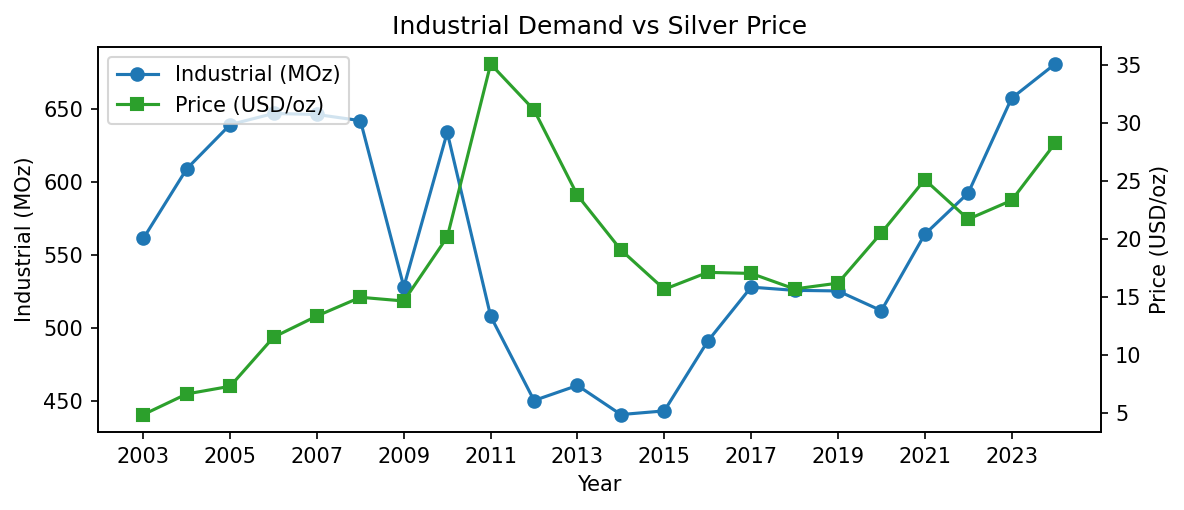

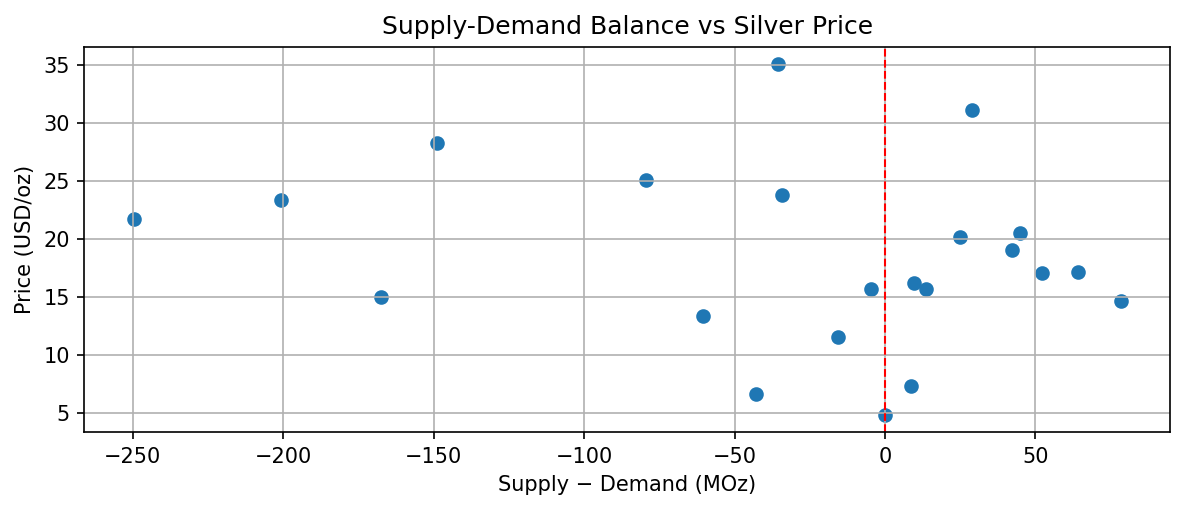

In [63]:
fig, ax1 = plt.subplots(figsize=(8,3.5))
ax1.plot(years, aligned['industrial_moz'], marker='o', label='Industrial (MOz)')
ax1.set_xlabel("Year"); ax1.set_ylabel("Industrial (MOz)")
ax2 = ax1.twinx()
ax2.plot(years, aligned['price_per_oz'], marker='s', color='tab:green', label='Price (USD/oz)')
ax2.set_ylabel("Price (USD/oz)")
ax1.set_xticks(years[::2])
lines, labs = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(lines + l2, labs + lab2, loc='upper left')
plt.title("Industrial Demand vs Silver Price")
plt.tight_layout(); plt.savefig(out_dir/"fig_industrial_vs_price.png")
plt.show()

plt.figure(figsize=(8,3.5))
balance = aligned['total_supply'] - aligned['total_demand_moz']
plt.scatter(balance, aligned['price_per_oz'])
plt.axvline(0, color='red', linewidth=1, linestyle='--')
plt.title("Supply-Demand Balance vs Silver Price")
plt.xlabel("Supply − Demand (MOz)"); plt.ylabel("Price (USD/oz)")
plt.grid(True); plt.tight_layout()
plt.savefig(out_dir/"fig_balance_vs_price.png")
plt.show()

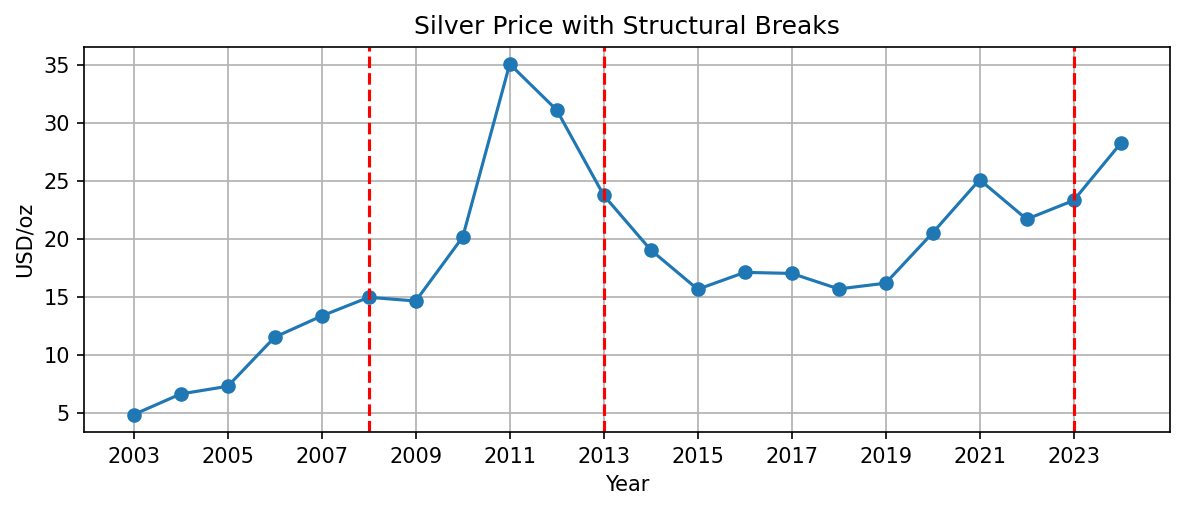

In [64]:
bk = [2008, 2013, 2023]

plt.figure(figsize=(8,3.5))
plt.plot(years, aligned['price_per_oz'], marker='o')
for b in bk:
    plt.axvline(b, color='red', linestyle='--')
plt.title("Silver Price with Structural Breaks")
plt.xlabel("Year"); plt.ylabel("USD/oz")
plt.xticks(years[::2]); plt.grid(True)
plt.tight_layout(); plt.savefig(out_dir/"fig_price_with_breaks.png")
plt.show()

/tmp/ipython-input-2185660972.py:17: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean = ratio_monthly.resample('A').mean()


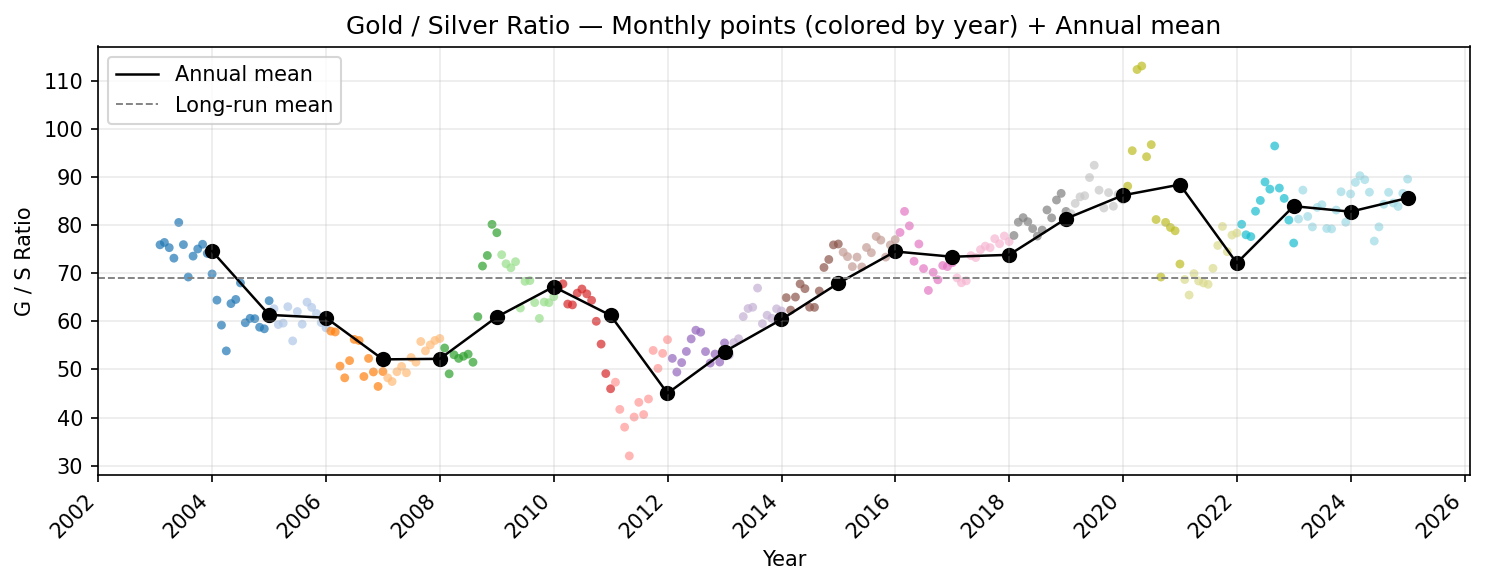

In [65]:
import matplotlib.dates as mdates

ratio_monthly = mkt_monthly['gold_fut'] / mkt_monthly['silver_fut']
ratio_monthly = ratio_monthly.dropna()
years_dt = ratio_monthly.index.year

# map each year to a color
years_unique = sorted(ratio_monthly.index.year.unique())
cmap = plt.get_cmap('tab20', len(years_unique))
color_map = {y: cmap(i) for i, y in enumerate(years_unique)}
colors = [color_map[y] for y in years_dt]

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(ratio_monthly.index, ratio_monthly.values, c=colors, s=18, alpha=0.7, edgecolors='none')

# plot annual means (larger black markers + line)
annual_mean = ratio_monthly.resample('A').mean()
ax.plot(annual_mean.index, annual_mean.values, '-k', linewidth=1.2, label='Annual mean')
ax.scatter(annual_mean.index, annual_mean.values, color='black', s=40)

# long-run mean
ax.axhline(ratio_monthly.mean(), color='gray', linestyle='--', linewidth=0.9, label='Long-run mean')

# x-axis formatting: year ticks every 2 years
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title("Gold / Silver Ratio — Monthly points (colored by year) + Annual mean")
ax.set_ylabel("G / S Ratio")
ax.set_xlabel("Year")
ax.grid(alpha=0.25)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(out_dir/"fig_gold_silver_ratio_improved.png")
plt.show()


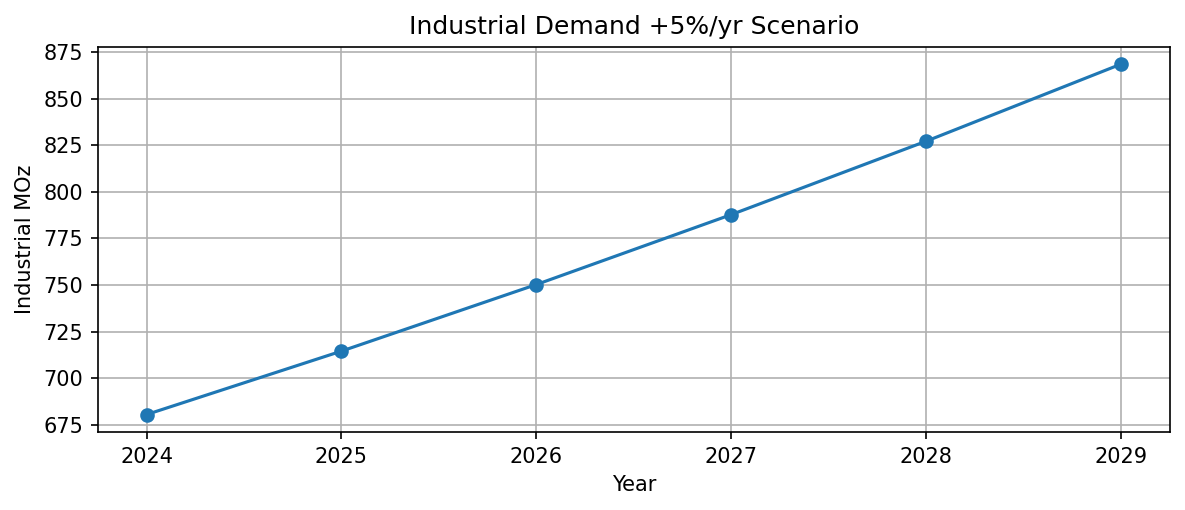

In [66]:
last_year = years.max()
future = np.arange(last_year, last_year+6)
base_ind = aligned.loc[last_year, 'industrial_moz']
scenario_ind = [base_ind * (1.05**i) for i in range(6)]

plt.figure(figsize=(8,3.5))
plt.plot(future, scenario_ind, marker='o')
plt.title("Industrial Demand +5%/yr Scenario")
plt.xlabel("Year"); plt.ylabel("Industrial MOz")
plt.xticks(future); plt.grid(True)
plt.tight_layout(); plt.savefig(out_dir/"fig_scenario_industrial.png")
plt.show()